In [172]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd.functional as func
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math

In [173]:
class Model(nn.Module):
    def __init__(self, in_features = 1, h1 = 10, out_features = 1):
        super().__init__()

        self.fc1 = nn.Linear(in_features, h1)
        # self.fc2 = nn.Linear(h1, h2)
        self.out = nn.Linear(h1, out_features)

    def forward(self, x):
        x = F.tanh(self.fc1(x))
        # x = F.sigmoid(self.fc2(x))
        x = self.out(x)
        return x

In [174]:
class CustomLoss(nn.Module):
    def __init__(self):
      super().__init__()

    def forward(self, grad_tens):

      grad_norm = torch.tensor(0.0)
      grad_norm.requires_grad = True

      grad_norm = (torch.sum(grad_tens**2))**0.5

      # grad_norm_tens = grad_norm.clone().detach().requires_grad_(True)

      return grad_norm


In [175]:
def calcGradients(model, mse_loss):

  row = []

  param_list = [model.fc1.weight, model.fc1.bias, model.out.weight, model.out.bias]

  grads = torch.autograd.grad(mse_loss, param_list, create_graph=True)

  row.append(grads[0].view(-1))
  row.append(grads[2].view(-1))

  # for name, param in model.named_parameters():

  #   print(param.grad)

  #   if (name == "fc1.weight" or name == "out.weight"):

  #     for g in param.grad.view(-1):

  #       row.append(g.view(-1))

  row_tens = torch.cat(row)

  return row_tens

In [176]:
def f(X):

  y = []

  for x in X:

    y.append(math.sin(5*math.pi*x)/(5*math.pi*x))

  return y

In [177]:
def hess_func(grad_tens):

  grad_sum = torch.sum(grad_tens**2)

  # grad_norm = (torch.sum(grad_tens)**2)**0.5

  row_list = []

  for g_i in grad_tens:

    row = []

    for g_j in grad_tens:

      hess_val = -g_i*g_j/((grad_sum)**(3/2))

      row.append(hess_val)

    row_tens = torch.tensor(row)

    row_list.append(row_tens)

  hess_tens = torch.stack(row_list)

  return hess_tens

In [178]:
def minRatio(grad_tens):

  grad_tens_clone = grad_tens.clone().detach()

  hessian_tensor = hess_func(grad_tens_clone)

  eigenvalues, _ = torch.linalg.eig(hessian_tensor)

  real_eigs = eigenvalues.real

  pos_eigs = real_eigs[real_eigs > 0]

  min_ratio = (pos_eigs.size(0))/ (real_eigs.size(0))

  return min_ratio

In [179]:
X = np.linspace(math.pi/1000, math.pi/2, 400)
y = f(X)

X = torch.tensor(X).float().unsqueeze(1)
X.requires_grad = True
y = torch.tensor(y).float().unsqueeze(1)

In [180]:
crit1 = torch.nn.MSELoss()
crit2 = CustomLoss()

model = Model()
optimizer = optim.SGD(model.parameters(), lr = .0001)

In [181]:
grad_loss_list = []
min_ratio_list = []

for i in range(100):

  if i==0:

    optimizer.zero_grad()

    y_pred = model(X)
    mse_loss = crit1(y_pred, y)
    mse_loss.backward()
    optimizer.step()

  else:

    y_pred = model(X)
    mse_loss = crit1(y_pred, y)
    grad_tens = calcGradients(model, mse_loss)
    grad_loss = crit2(grad_tens)


    optimizer.zero_grad()

    grad_loss.backward()

    optimizer.step()

    if i<10 or i>90:

      min_ratio_list.append(minRatio(grad_tens))

      grad_loss_list.append(grad_loss.item())




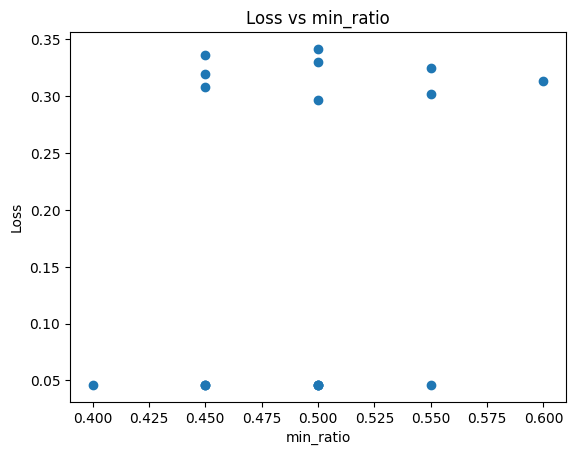

In [182]:
plt.title("Loss vs min_ratio")
plt.xlabel("min_ratio")
plt.ylabel("Loss")
plt.scatter(min_ratio_list, grad_loss_list)